In [2]:
import numpy as np
import pandas as pd
import os
import itertools
import glob
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import f1_score
from sklearn import metrics

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [4]:
NUMOFPARAMS = 8
OrderOfColumnsForTraining = ['fident', 'bits', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'tlen',
       "FracOfPf","p_evalue", 'query', 'target','qstart',
       'qend', 'tstart', 'tend', 'qlen','PredPF', 'PF', 'PFstart', 'PFend', 'evalue', 'Status']

#It assumes all the parameters used for the training are located in the first columns of the X

In [5]:
from numpy import log
    
def PreprocessingLabeledData(df):
    """This is for calculating the pfam coverage, and replacing 0 e-values, it will also change
    the order of the columns. Before running this, the input must have been labeled. """
    df["FracOfPf"] = (df["tend"] -df["tstart"] + 1)/df["tlen"]
    df["p_evalue"] = -log(df["evalue"] + 1e-300)
    df["MismatchRatio"] = df["mismatch"]/df['alnlen'] *100
    df["GapOpenRatio"] = df["gapopen"]/df['alnlen'] *100
    df = df[OrderOfColumnsForTraining] #This is for putting the parameters
    # to learn from in the beginning, and for selecting the needed columns
    return df

In [6]:
%matplotlib inline

In [7]:
LabeledDataAddressDict = {}
LabeledDataAdds = sorted(glob.glob("../intermediates/*/aln_*_pf_seq_e3_labeled.tsv"))
DictOfAdds = {os.path.normpath(x).split(os.sep)[2]:x for x in LabeledDataAdds}
FullNameDict = {"Sc": "S. cerevisiae", "Ec":"E. coli","Mj":"M. jannaschii", "Tb":"T. brucei"}

In [8]:
AddressTbData = DictOfAdds["Tb"]
TbData = pd.read_csv(AddressTbData, sep="\t")
TbData = PreprocessingLabeledData(TbData)

LabeledData_tb = TbData[TbData["Status"]!=-1]
#I shuffle all the samples at this stage
LabeledData_tb = LabeledData_tb.sample(frac=1, random_state=1).reset_index(drop=True)

X_tb_labeled = LabeledData_tb[OrderOfColumnsForTraining].values # The alignments of Tb will have a distinct naming convention
y_tb_labeled = LabeledData_tb['Status'].values # The alignments of Tb will have a distinct naming convention

del LabeledData_tb

UnLabeledData_tb = TbData[TbData["Status"]==-1]
X_tb_unlabeled = UnLabeledData_tb[OrderOfColumnsForTraining].values # The alignments of Tb will have a distinct naming convention
y_tb_unlabeled = UnLabeledData_tb['Status'].values # The alignments of Tb will have a distinct naming convention
del UnLabeledData_tb
del TbData


In [9]:
totalNumAli = X_tb_labeled.shape[0] + X_tb_unlabeled.shape[0]
print("There are a total of {} possible alignments between Proteome of interest and Pfam instances".format(totalNumAli))
print("{} percent of the data is labeled as 1 ".format(y_tb_labeled[y_tb_labeled[:]==1].shape[0]*100/totalNumAli))
print("{} percent of the data is labeled as 0 ".format(y_tb_labeled[y_tb_labeled[:]==0].shape[0]*100/totalNumAli))


There are a total of 208748 possible alignments between Proteome of interest and Pfam instances
94.01527200260601 percent of the data is labeled as 1 
5.616820280912871 percent of the data is labeled as 0 


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_tb_labeled, y_tb_labeled, train_size = 0.6, test_size=0.4, shuffle=False)
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, train_size = 0.5, test_size=0.5, shuffle=False)

In [22]:
PFindex = OrderOfColumnsForTraining.index("PF") #Finding the PFs in the training set
TrainingPFs = np.unique(X_train[:,PFindex])

In [24]:
from imblearn.over_sampling import SMOTE
smoter = SMOTE()
X_train, y_train = smoter.fit_resample(X_train[:,:NUMOFPARAMS], y_train)

In [25]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
rf.fit(X_train[:,:NUMOFPARAMS], y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [ ]:
#import joblib
#joblib.dump(rf, "./PFAS_RF.joblib", compress=3)

In [26]:
ModelDict = {}
TrainSizes = [0.01] #Add whatever fraction you want to test to this dictionary
ModelDict[1] = rf
for train_size in TrainSizes:
    X_train_frac, X_test_frac, y_train_frac, y_test_frac = train_test_split(X_train,y_train, train_size = train_size, test_size=1- train_size, shuffle=False)
    rf = RandomForestClassifier(n_estimators=100, criterion='gini', n_jobs=-1)
    rf.fit(X_train_frac[:,:NUMOFPARAMS], y_train_frac)
    ModelDict[train_size] = rf
del X_train_frac, X_test_frac, y_train_frac, y_test_frac

In [27]:
X_dict_orgs = {}
y_dict_orgs = {}

for org in DictOfAdds:
    if org == "Tb":
        continue 
    Data = pd.read_csv(DictOfAdds[org], sep="\t")
    Data = PreprocessingLabeledData(Data)
    print("The summary of the alignments for {}".format(org))
    print("There are total of {} possible alignments between Proteome of {} and Pfam instances".format(Data.shape[0], org))
    totalNum = Data.shape[0]
    print("{} percent of the data is labeled 1 ".format(Data[Data["Status"]==1].shape[0]/totalNum*100))
    print("{} percent of the data is labeled 0 ".format(Data[Data["Status"]==0].shape[0]/totalNum*100))
    Data = Data[Data["Status"]!=-1]
    X_dict_orgs[org] = Data[OrderOfColumnsForTraining].values
    y_dict_orgs[org] = Data['Status'].values
    del Data

The summary of the alignments for Ec
There are total of 382837 possible alignments between Proteome of Ec and Pfam instances
97.26463220639593 percent of the data is labeled 1 
2.470764320063108 percent of the data is labeled 0 
The summary of the alignments for Mj
There are total of 99911 possible alignments between Proteome of Mj and Pfam instances
95.07561729939647 percent of the data is labeled 1 
4.555053998058272 percent of the data is labeled 0 
The summary of the alignments for Sc
There are total of 310049 possible alignments between Proteome of Sc and Pfam instances
96.29090885634206 percent of the data is labeled 1 
3.3514057455434463 percent of the data is labeled 0 


In [28]:
def PrepareDataForAUCplot(model, X):
    PFindex = OrderOfColumnsForTraining.index("PF")
    PF = X[:, PFindex]
    y_pred_prob = model.predict_proba(X[:,:NUMOFPARAMS])[:, 1]
    LabelsIndex = OrderOfColumnsForTraining.index("Status")
    Labels = X[:, LabelsIndex]
    Summary = pd.DataFrame({"Label": Labels, "PF":PF, "PredProb": y_pred_prob})
    return Summary  

In [29]:
def Input4AUCplot(AlnDF, ExcPFList):
    PlotDF = AlnDF[~AlnDF["PF"].isin(ExcPFList)]
    fpr, tpr, _ = metrics.roc_curve(PlotDF["Label"].astype(int), PlotDF["PredProb"])
    auc = round(metrics.roc_auc_score(PlotDF["Label"].astype(int), PlotDF["PredProb"]),3)
    return fpr,tpr,auc    

In [30]:
def PlotAUC(PlotParams,org, labels):
    if len(labels)==0:
        plt.plot(PlotParams[0],PlotParams[1],label= "$\it{" + FullNameDict[org] +"}$, AUC="+str(PlotParams[2]))
    else:
        plt.plot(PlotParams[0],PlotParams[1],label= "$\it{" + FullNameDict[org] +"}$, " + ", ".join(labels) +", AUC="+str(PlotParams[2]))
    

<Figure size 640x480 with 0 Axes>

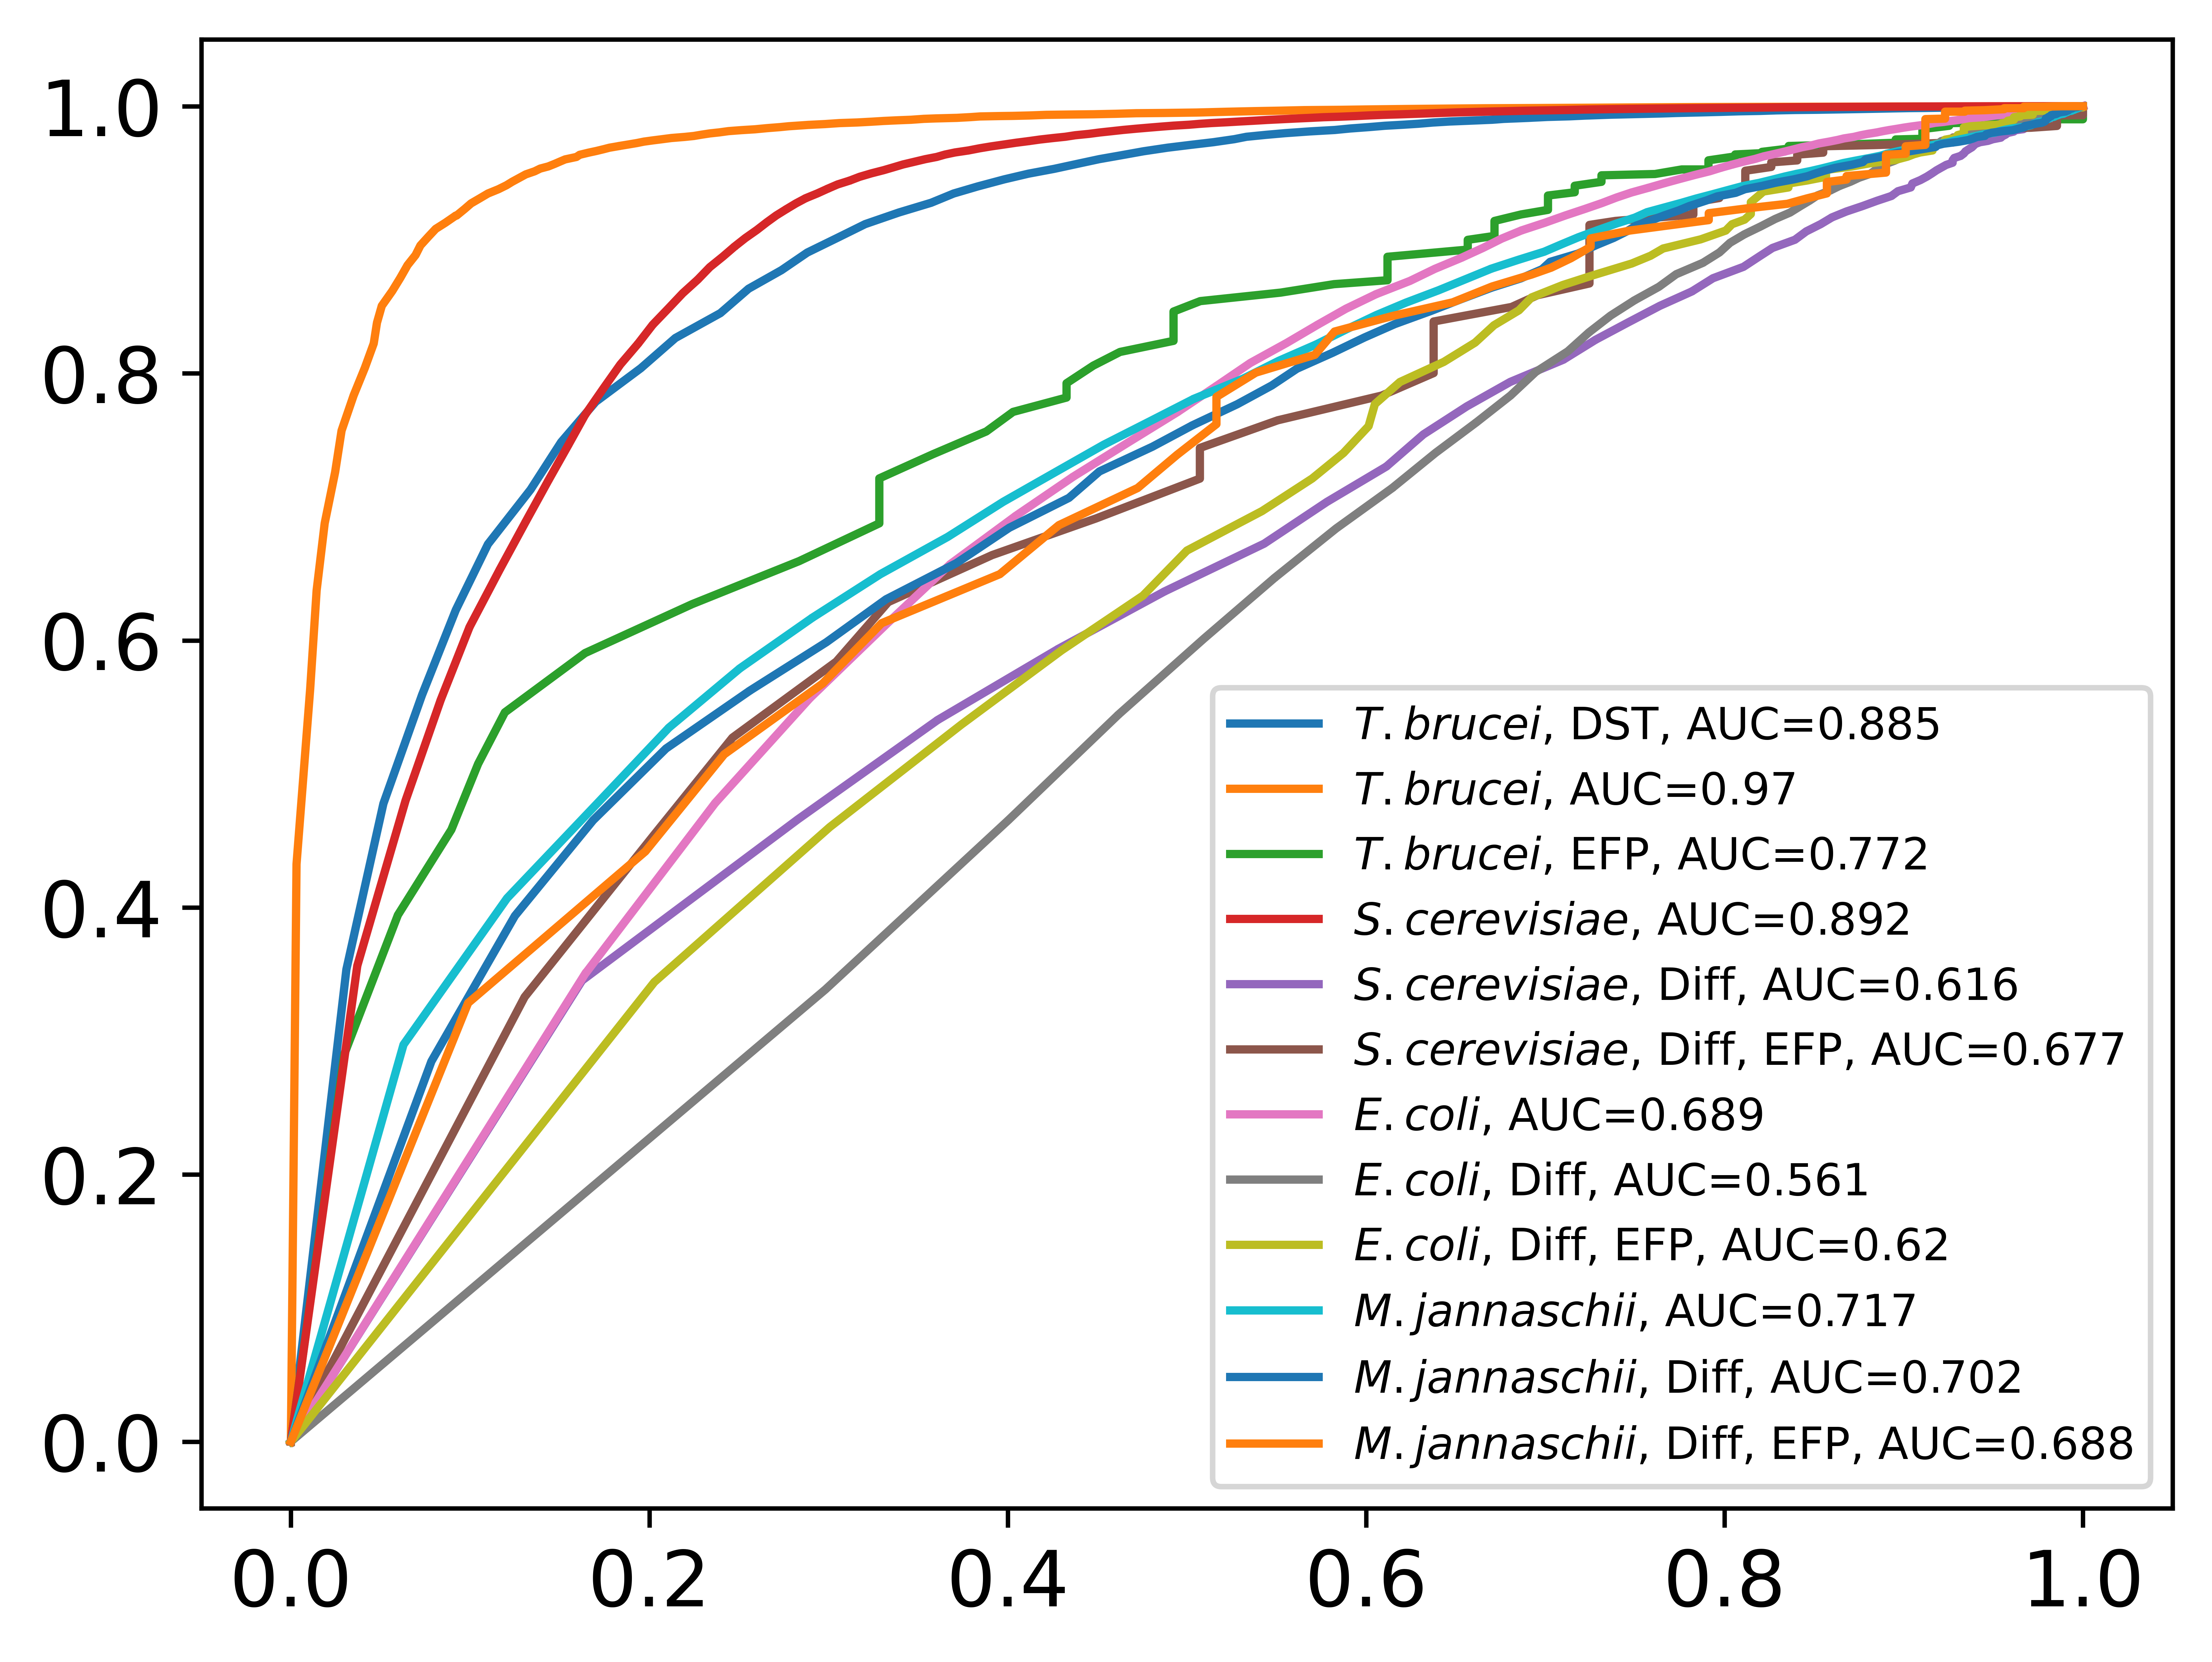

In [32]:
plt.figure(0).clf()
plt.figure(dpi=1200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Pars = Input4AUCplot(PrepareDataForAUCplot( ModelDict[0.01], X_test), [])
PlotAUC(Pars, "Tb", ["DST"])

for org in ["Tb", "Sc", "Ec", "Mj"]:
    if org=="Tb":
        X_ = X_test
    else:
        X_ = X_dict_orgs[org] 
    tags = []
    AlnSummary = PrepareDataForAUCplot(ModelDict[1], X_)
    Params = Input4AUCplot(AlnSummary,[] )
    PlotAUC(Params,org, tags)
    if org!= "Tb":
        AlnSummary = AlnSummary[~AlnSummary["PF"].isin(TrainingPFs)]
        tags = ["Diff"]  #The diff tag is for showing that AUC has been calculated on proteins with Pfams different than the training PFs
        #Params = Input4AUCplot(AlnSummary,[] )
        PlotAUC(Input4AUCplot(AlnSummary,[] ),org, tags)
    GroupedByPF = AlnSummary.groupby("PF").size()
    Threshold = int(GroupedByPF.quantile(0.5))
    HighFreqs = GroupedByPF[GroupedByPF>Threshold].index
    tags += ["EFP"] #EFP stands for excluding frequent pfams. I find the number of times each Pfam had been observed in the queries, and exclude those whose frequency was above the median of frequency
    PlotAUC(Input4AUCplot(AlnSummary,HighFreqs ),org, tags)
    
    #excluding frequents
    #excluding Tb
    
plt.legend(prop={'size': 8})
#plt.legend(bbox_to_anchor=(1.55, 0.3))
#Pars = Input4AUCplot(PrepareDataForAUCplot( ModelDict[1], X_test), [])
#PlotAUC(Pars, "Tb", [])